# Testing transferability between Random Forest and SVM

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from rfa import RandomForestAttack

In [2]:
# Autoreload python files
%load_ext autoreload
%autoreload 2

## Prepare data

In [3]:
SEED = 0
X, y = make_blobs(n_samples=1000, n_features=2, centers=4,
                  random_state=SEED, cluster_std=1.0)
# Rescaling to [-1, 1]
X_max = np.max(X, axis=0)
X_min = np.min(X, axis=0)
X = 1 - 2 * (X - X_min)/(X_max - X_min)

Rescale data to [-1, 1] range

In [4]:
X_max = np.max(X, axis=0)
X_min = np.min(X, axis=0)
X = 1 - 2 * (X - X_min)/(X_max - X_min)

Split train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(800, 2) (200, 2)


## Train SVM model

In [6]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [7]:
print('Accuracy on train set: {:.2f}'.format(svm_model.score(X_train, y_train)*100))
print('Accuracy on test set:  {:.2f}'.format(svm_model.score(X_test, y_test)*100))

Accuracy on train set: 93.12
Accuracy on test set:  92.50


In [8]:
pred_train_svm = svm_model.predict(X_train)
pred_test_svm = svm_model.predict(X_test)

## Train a Random Forest Classifier as the surrogate model

In [9]:
N_TREES = 12

In [10]:
rf_model = RandomForestClassifier(n_estimators=N_TREES)
rf_model.fit(X_train, pred_train_svm)

RandomForestClassifier(n_estimators=12)

In [11]:
print("Performance on surrogate model:")
print('Accuracy on train set: {:.2f}%'.format(svm_model.score(X_train, pred_train_svm)*100))
print('Accuracy on test set:  {:.2f}%'.format(svm_model.score(X_test, pred_test_svm)*100))

Performance on surrogate model:
Accuracy on train set: 100.00%
Accuracy on test set:  100.00%


## Visualise SVM and RF

In [12]:
def visualize_classifier(model, X, y, title=None):
    """The decision boundary can only draw on 2D space"""
    cmap='rainbow'
    plt.figure(figsize=(7, 7))
    ax = plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, 
               clim=(y.min(), y.max()), zorder=3)
    xlim = (-1.0, 1.0)
    ylim = (-1.0, 1.0)
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    if title is not None:
        plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.show()

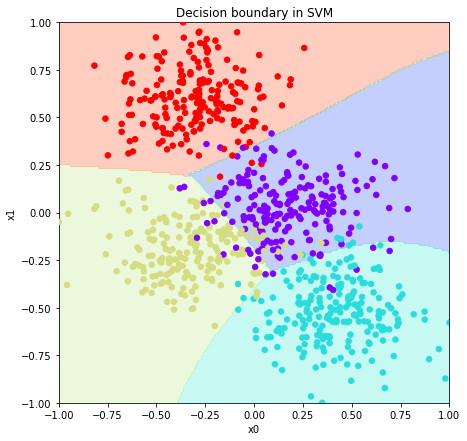

In [13]:
visualize_classifier(svm_model, X_train, y_train, title="Decision boundary in SVM")

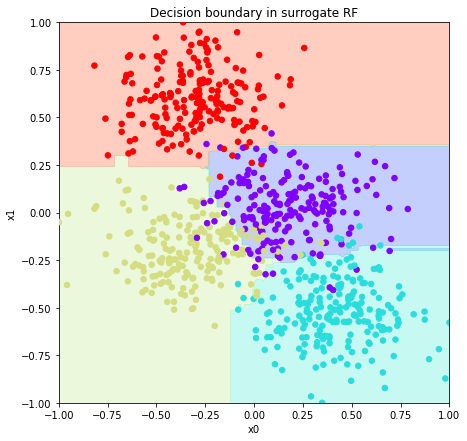

In [14]:
visualize_classifier(rf_model, X_train, y_train, title="Decision boundary in surrogate RF")

## Attack the surrogate model with Random Forest Attack

In [15]:
# Hyperparameters
N_THREADS = 1
EPSILON = 1e-4  # The minimum change to update a feature.
MAX_BUDGET = 0.01 * X.shape[1]   # The max. perturbation is allowed.
# rule : {'least_leaf', 'least_root', 'least_global', 'random'}
PICK_RULE = 'least_leaf'

In [16]:
attack = RandomForestAttack(rf_model, max_budget=MAX_BUDGET, epsilon=EPSILON,
                            rule=PICK_RULE, n_threads=N_THREADS)

In [17]:
start = time.time()
X_adv = attack.generate(X_test, y_test)
time_elapsed = time.time() - start
print('Time to complete: {:d}m {:.3f}s'.format(int(time_elapsed // 60), time_elapsed % 60))

String the   10th data point...
String the   20th data point...
String the   30th data point...
String the   40th data point...
String the   50th data point...
String the   60th data point...
String the   70th data point...
String the   80th data point...
String the   90th data point...
String the  100th data point...
String the  110th data point...
String the  120th data point...
String the  130th data point...
String the  140th data point...
String the  150th data point...
String the  160th data point...
String the  170th data point...
String the  180th data point...
String the  190th data point...
String the  200th data point...
Time to complete: 0m 8.337s


### Performance on the surrogate RF classifier

In [18]:
pred_test_rf = rf_model.predict(X_test)
acc = np.count_nonzero(pred_test_rf == y_test) / len(X_test)
print('Accuracy on test set = {:.2f}%'.format(acc*100))

adv_pred_test_rf = rf_model.predict(X_adv)
acc = np.count_nonzero(adv_pred_test_rf == y_test) / len(X_test)
print('Accuracy on adversarial example set = {:.2f}%'.format(acc*100))

Accuracy on test set = 92.00%
Accuracy on adversarial example set = 2.00%


### Performance on original SVM

In [19]:
acc = np.count_nonzero(pred_test_svm == y_test) / len(X_test)
print('Accuracy on test set = {:.2f}%'.format(acc*100))

adv_pred_test_svm = svm_model.predict(X_adv)
acc = np.count_nonzero(adv_pred_test_svm == y_test) / len(X_test)
print('Accuracy on adversarial example set = {:.2f}%'.format(acc*100))

Accuracy on test set = 92.50%
Accuracy on adversarial example set = 56.50%


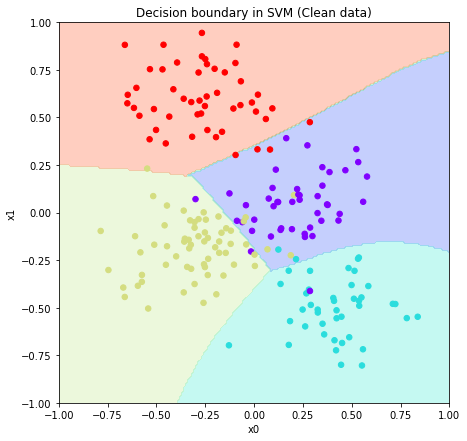

In [20]:
visualize_classifier(svm_model, X_test, y_test, title="Decision boundary in SVM (Clean data)")

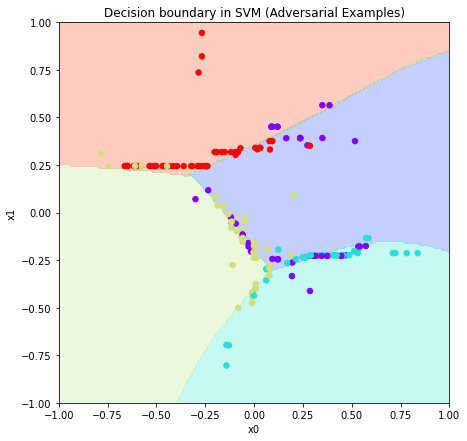

In [21]:
visualize_classifier(svm_model, X_adv, y_test, title="Decision boundary in SVM (Adversarial Examples)")

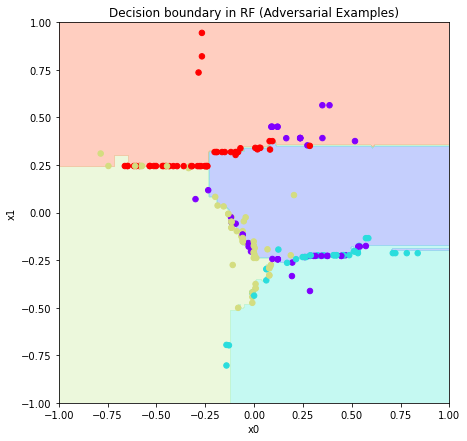

In [22]:
visualize_classifier(rf_model, X_adv, y_test, title="Decision boundary in RF (Adversarial Examples)")